In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load files 
run_info = pd.read_csv("./run_info.csv") # stores config information of each run
print(run_info.columns) 
cross_validation = pd.read_csv("./cross_validation.csv", header=None) # ERM evaluations, (i,j) entry is accuracy evaluated on domain j after training on 1000 samples from doamin i
cross_validation = cross_validation.values
print(cross_validation)

Index(['run', 'domains', 'method', 'id'], dtype='object')
[[0.6494  0.1652  0.3111  0.09699 0.4735  0.287  ]
 [0.3247  0.4174  0.3926  0.05351 0.4875  0.2963 ]
 [0.3247  0.2435  0.763   0.0903  0.6072  0.3889 ]
 [0.1299  0.04348 0.05926 0.7458  0.1142  0.1019 ]
 [0.4156  0.1478  0.437   0.08027 0.8384  0.3796 ]
 [0.4286  0.09565 0.2444  0.1739  0.4652  0.6574 ]]


In [15]:
# Calculate data efficiencies of active learning under different domain compositions
threshold_round = 60 # the query at which we select margin's val acc and use that to find data efficiency compared with random
smoothing_factor = 5 # take mean(rounds i to i + smoothing_factor - 1) as value for round i, smooth out stochastic variance

al_performance = pd.read_csv("./al_performance.csv")
num_runs = al_performance.shape[1] - 1
run_names = list(al_performance.columns)[1:]

al_perf_dict = {}
runs = []
effs = []
for i in range(num_runs):
    run_name = run_names[i]
    info = run_info.loc[run_info['run']==run_name]
    # print(info)
    if info['method'].values[0] == 'margin':
        margin_perf = al_performance.loc[:, run_name].values
        random_dual_info = run_info.loc[(run_info['domains'] == info['domains'].values[0]) & (run_info['method'] == 'random')]
        # print(random_dual_info)
        random_name = random_dual_info['run'].values[0]
        random_perf = al_performance.loc[:, random_name].values
        
        smoothed_margin_perf = [np.mean(margin_perf[i: i+smoothing_factor]) for i in range(len(margin_perf)-smoothing_factor + 1)]
        smoothed_random_perf = [np.mean(random_perf[i: i+smoothing_factor]) for i in range(len(random_perf)-smoothing_factor + 1)]
        threshold_acc = smoothed_margin_perf[threshold_round]
        first_matching_index = np.sort(np.nonzero(smoothed_random_perf > threshold_acc)[0])[0]
        efficiency = first_matching_index / threshold_round
        # print(f"matching index is {first_matching_index}")
        # print(f"data efficiency is {efficiency}")
        al_perf_dict[run_name] = efficiency
        runs.append(run_name)
        effs.append(efficiency)

In [19]:
print(f"Number of datapoints: {len(runs)}")
print(al_perf_dict)

Number of datapoints: 14
{'margin_nosketch-2a7r48ur': 1.5833333333333333, 'margin_noclip_paint-12y1yy66': 1.45, 'margin_paint_quick_real-180euuq7': 1.75, 'margin_info_paint_quick-2i5ddcd9': 1.7, 'margin_noquick_sketch-2ui586n7': 1.95, 'margin_clip_quick_real-2yesp4ji': 1.2166666666666666, 'margin_paint_real_sketch-h5nl4egc': 2.216666666666667, 'margin_nopaint_real-jdfh8v5v': 1.0833333333333333, 'margin_noquickdraw_real-1m5myjkn': 0.9666666666666667, 'margin_nopainting_sketch-3o9jdbpv': 1.0833333333333333, 'margin_noquickdraw-1uy4ywmf': 1.2833333333333334, 'margin_noinfograph-2oap9tih': 1.4833333333333334, 'margin_noreal-2txy2u4x': 0.95, 'margin_noinfograph_real-3n79cu33': 1.1833333333333333}


In [9]:
# Calculate prediction metrics
# metric1 = sum_i natural_weight(i) sum_j selection_weight(j) acc(j->i)
# metric2 = sum_i natural_weight(i) sum_j selection_weight(j) acc(j->i)/acc(i->i)

In [10]:
# DOMAIN_NET_DOMAINS = ["clipart", "infograph", "painting", "quickdraw", "real", "sketch"]
num_domain = 6
natural_counts = np.array([3672, 5069, 6553, 14000, 15985, 5466])

In [11]:
# Load selection frequency files and calculate margin's selection weight
n = 3 # use the average selection freq of the first n query rounds as heuristics for al selection weight
freq = pd.read_csv(f"./selection_frequency/0.csv")
columns = list(freq.columns)
selection_freq = pd.DataFrame(data = np.zeros((num_domain, len(columns))), columns=columns)
for i in range(num_domain):
    domain = i 
    file = f"./selection_frequency/{domain}.csv"
    freq = pd.read_csv(file)
    # print(freq.shape)
    first_n_rounds = freq.iloc[:n, :].to_numpy()
    average = np.mean(first_n_rounds, axis = 0)
    selection_freq.iloc[i, :] = average
print(f"Calculated selection_freq is of shape {selection_freq.shape}")

Calculated selection_freq is of shape (6, 14)


In [12]:
# For each datapoint (domain composition), calculate prediction metrics
metrics1 = []
metrics2 = []
for run in runs:
    # print(run)
    domain_str = str(run_info.loc[run_info['run'] == run, 'domains'].values[0])
    # print(domain_str)
    domains = [int(g) - 1 for g in domain_str]
    # print(domains)
    mask = np.zeros(num_domain)
    mask[domains] = 1
    natural_weight = mask * natural_counts 
    natural_weight = natural_weight / np.sum(natural_weight)
    # print(natural_weight)
    selection_weight = selection_freq.loc[:,run].values / 100
    # print(selection_weight)
    metric1 = np.sum(np.sum(cross_validation * selection_weight.reshape((-1, 1)), axis = 0) * natural_weight)
    metrics1.append(metric1)
    diagonal = np.reshape(np.diagonal(cross_validation), (1, -1))
    metric2 = np.sum(np.sum(cross_validation / diagonal * selection_weight.reshape((-1, 1)), axis = 0) * natural_weight)
    metrics2.append(metric2)

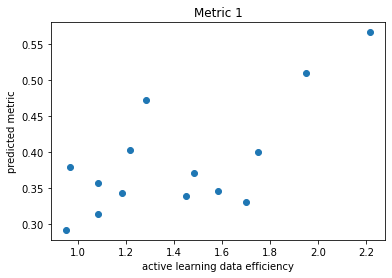

In [17]:
plt.scatter(effs, metrics1, label="al performance prediction")
plt.title("Metric 1")
plt.xlabel("active learning data efficiency")
plt.ylabel("predicted metric")
plt.show()

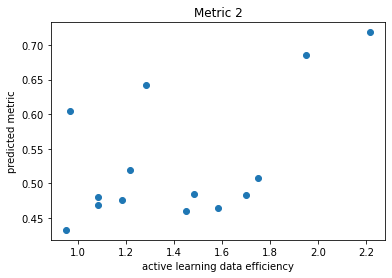

In [18]:
plt.scatter(effs, metrics2, label="al performance prediction")
plt.title("Metric 2")
plt.xlabel("active learning data efficiency")
plt.ylabel("predicted metric")
plt.show()